In [1]:
from scipy.stats import alpha
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

In [2]:
import sqlite3
import pandas as pd
import seaborn as sns

with sqlite3.connect('../data/models.db') as conn:
    df = pd.read_sql('SELECT * FROM models WHERE exp_id=0', conn)

for col in ['val_acc', 'train_acc', 'time', 'flops', 'macs', 'params', 'exp_id']:
    df[col] = df[col].apply(eval)
    
df.sort_values(by='val_acc', ascending=False, inplace=True)

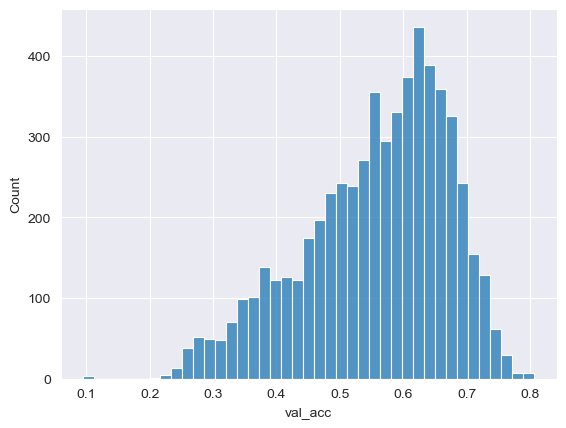

In [3]:
sns.histplot(df.val_acc);

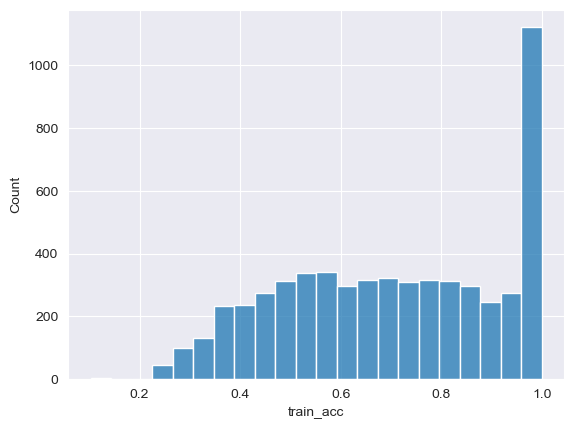

In [4]:
sns.histplot(df.train_acc);

In [5]:
from sophius.encode import Encoder, str_to_vec

encoder = Encoder()

df['vec'] = df['hash'].apply(str_to_vec)
df['seq_len'] = df.vec.apply(len)

C:\Users\korol\miniforge3\envs\sophius\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Axes: >

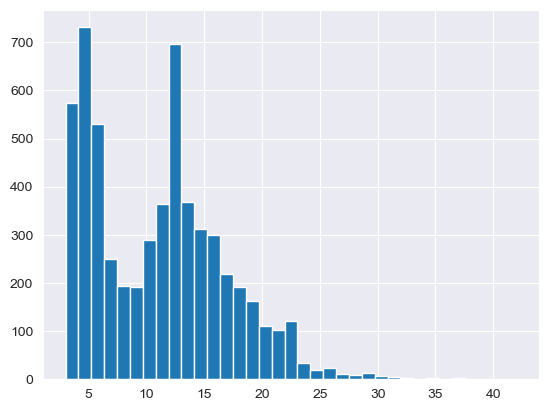

In [6]:
df.seq_len.hist(bins=35);

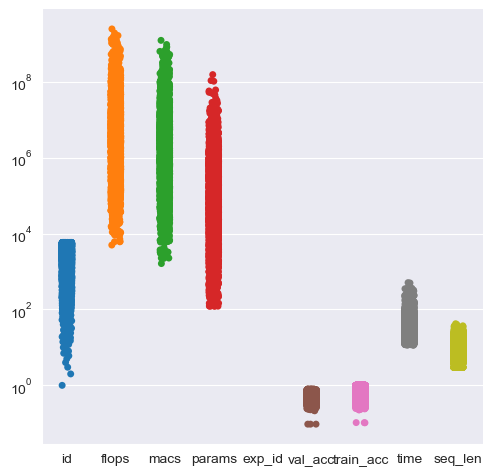

In [13]:
import matplotlib.pyplot as plt
sns.catplot(df);
plt.yscale('log')

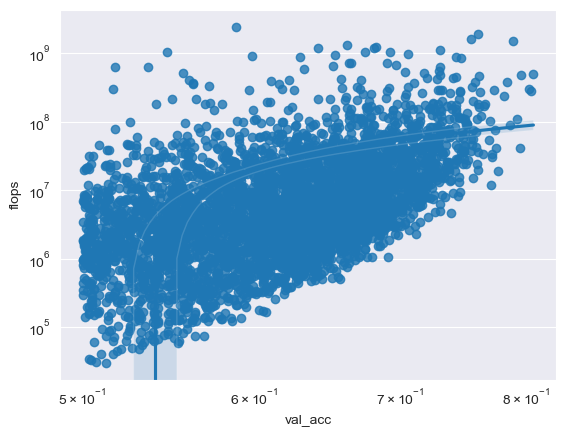

In [15]:
sns.regplot(df.query('val_acc > 0.5'), x='val_acc', y='flops');
plt.xscale('log')
plt.yscale('log')

In [22]:
# df.query('seq_len > 8').seq_len.hist(bins=25)

In [23]:
# df = df.query('seq_len > 8')
# df = df.query('val_acc >')

In [16]:
import torch
import pytorch_lightning as pl
from torch.utils.data import random_split
from sophius.dataload import SequenceLoader, SequenceDataset

RANDOM_SEED = 42

torch.manual_seed(RANDOM_SEED)

dataset = SequenceDataset(df.vec.tolist(), df.val_acc.values)
train, val = random_split(dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(RANDOM_SEED))

In [17]:
import pytorch_lightning as pl
import torch
from torch.nn import functional as F


class LSTMRegLightning(pl.LightningModule):
    def __init__(self,
                 input_dim=32,
                 hidden_dim=128,
                 num_layers=1,
                 dropout=0.0,
                 lr=1e-3,
                 gamma=0.9,                 
                 **_):
        super().__init__()
        self.save_hyperparameters()  # Save hyperparameters
        self.lstm = torch.nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, 1)
        self.lr = lr
        self.gamma = gamma
        self.val_loss = None

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        return self.fc(hidden[-1])

    def training_step(self, batch, batch_idx):
        sequences, targets = batch
        outputs = self(sequences)
        targets = targets.view(-1, 1)
        loss = F.mse_loss(outputs, targets)
        self.log('train_loss', loss, on_step=True, on_epoch=False, prog_bar=False)
        # self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        sequences, targets = batch
        outputs = self(sequences)
        targets = targets.view(-1, 1)
        loss = F.mse_loss(outputs, targets)
        self.log('val_loss', loss, on_step=True, on_epoch=False, prog_bar=False)
        self.val_loss.append(loss)
        return loss

    def on_validation_epoch_start(self) -> None:
        self.val_loss = []

    def on_validation_epoch_end(self):
        avg_val_loss = torch.mean(torch.stack(self.val_loss))
        # print('val', avg_val_loss, len(self.val_loss))
        self.log('hp_metric', avg_val_loss)

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=self.lr)
        return {
            'optimizer': opt,
            'lr_scheduler': torch.optim.lr_scheduler.ExponentialLR(opt, gamma=self.gamma)
        }

In [19]:
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

def plot_results(model, dataset):
    # plt.figure(figsize=(6, 6))
    # plt.gca().set_aspect('equal', adjustable='box')
    res = pd.DataFrame(columns=['y_pred', 'y_true'])
    model.eval()
    model = model.cuda()
    
    with torch.no_grad():
        for seq, y_true in dataset:
            y_pred = model(seq.unsqueeze(0)).item()
            y_true = y_true.item()
            res.loc[len(res)] = [y_pred, y_true]
    
    print(f'MSE: {mean_squared_error(res.y_true, res.y_pred):.4f}')
    print(f'R^2: {r2_score(res.y_true, res.y_pred):.4f}')
    sns.regplot(res, x='y_pred', y='y_true')#.set_aspect('equal', adjustable='datalim')

## Train lightning model

In [18]:
import warnings
from tqdm import tqdm
from pytorch_lightning.callbacks import TQDMProgressBar

class CustomProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        return tqdm(disable=True)

warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")

hparams = {
    'lr': 1e-3,
    'gamma': 1,
    'hidden_dim': 32,
    'num_layers': 2,
    'dropout': 0.5,
    'input_dim': 32,
    'num_epochs': 20,
    'batch_size': 8,
}

# train_loader = DataLoader(train, batch_size=1, shuffle=False, num_workers=0)
# val_loader = DataLoader(val, batch_size=1, shuffle=False, num_workers=0)
# train_loader = SimpleLoader(train)
# val_loader = SimpleLoader(val)
train_loader = SequenceLoader(train, batch_size=hparams['batch_size'])
val_loader = SequenceLoader(val, batch_size=hparams['batch_size'])


# Initialize model
model = LSTMRegLightning(**hparams)



# Create PyTorch Lightning trainer
trainer = pl.Trainer(
    max_epochs=hparams['num_epochs'], 
    accelerator='gpu', 
    log_every_n_steps=4,
    callbacks=[CustomProgressBar()],
)

# Train the model
model.train()
# print(model.device)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | lstm | LSTM   | 16.9 K
1 | fc   | Linear | 33    
--------------------------------
16.9 K    Trainable params
0         Non-trainable params
16.9 K    Total params
0.068     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 728/728 [00:06<00:00, 121.22it/s, loss=0.0034, v_num=34] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 728/728 [00:06<00:00, 121.09it/s, loss=0.0034, v_num=34]


MSE: 0.0023
R^2: 0.8258


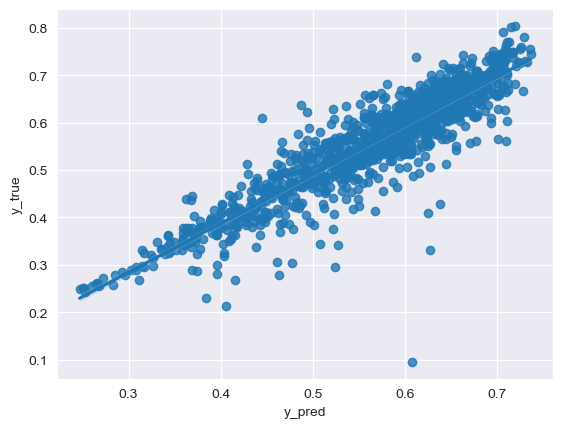

In [22]:
plot_results(model, val);

## Train torch model

In [28]:
from sophius.estimate import LSTMRegressor

reg = LSTMRegressor(**hparams).cuda()

opt = torch.optim.Adam(reg.parameters(), lr=hparams['lr'])
sch = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=hparams['gamma'])
loader = SequenceLoader(dataset, batch_size=hparams['batch_size'])

reg.train()
pb = tqdm(total=hparams['num_epochs'])
for i in range(hparams['num_epochs']):
    pb.set_description(f'Epoch {i+1:2d}')
    for (x, y) in loader:
        y_pred = reg(x)
        loss = F.mse_loss(y_pred, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        sch.step()
    pb.update(1)
        
torch.save(reg, '../data/models/estimator_v1.pth')

Epoch 20: 100%|██████████| 20/20 [01:16<00:00,  3.96s/it]

MSE: 0.0026
R^2: 0.7970


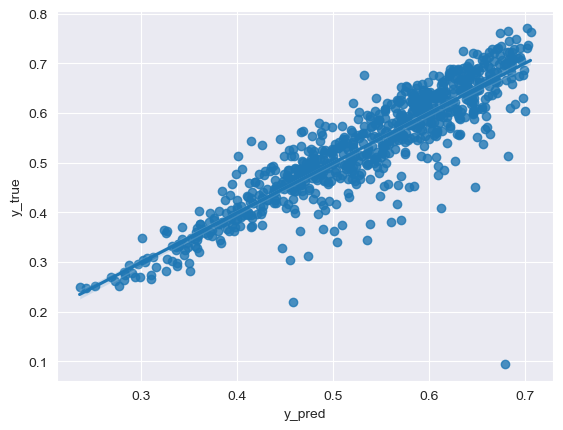

In [112]:
# p 0.5 gamma 0.95
plot_results(model, val)

MSE: 0.0027
R^2: 0.7913


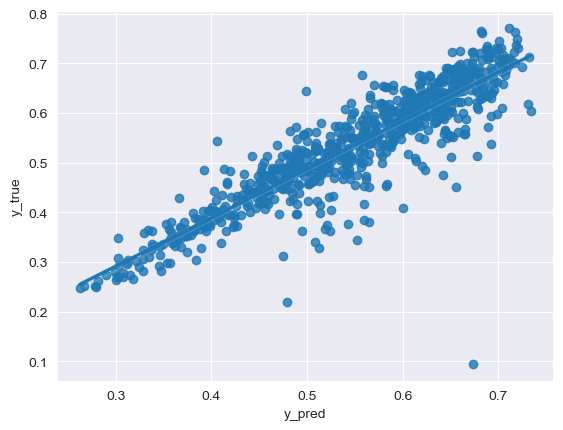

In [110]:
# p 0.4
plot_results(model, val)

MSE: 0.0028
R^2: 0.7845


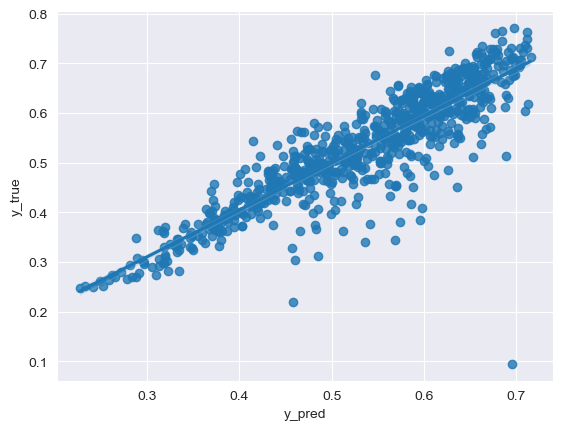

In [108]:
# p 0.6
plot_results(model, val)

MSE: 0.0046
R^2: 0.6474


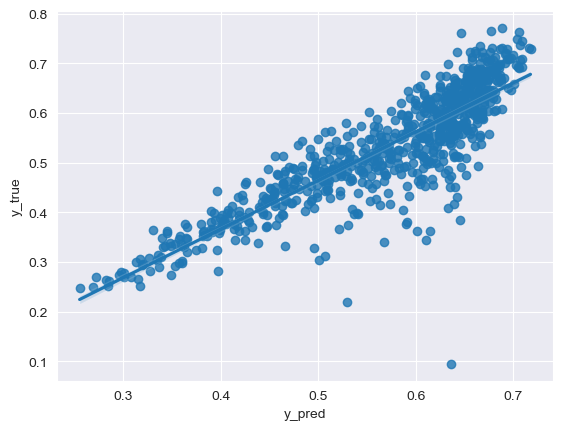

In [100]:
# dim 16 lay 2
plot_results(model, val)

MSE: 0.0026
R^2: 0.8039


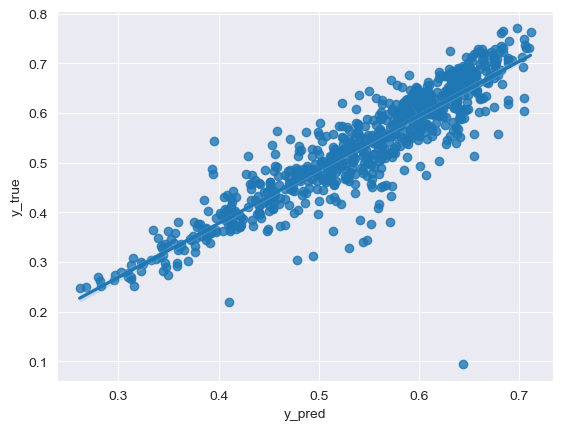

In [98]:
# dim 24 lay 2
plot_results(model, val)

MSE: 0.0030
R^2: 0.7678


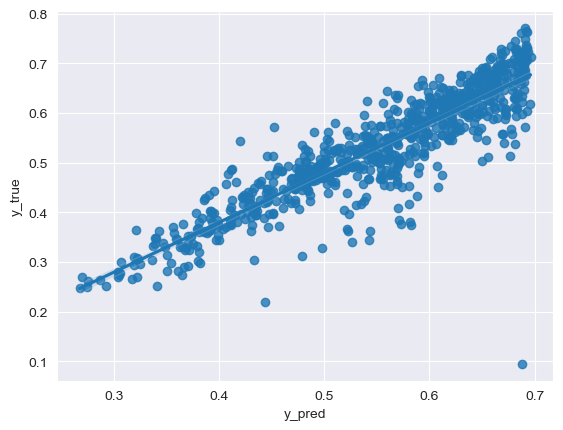

In [106]:
# dim 24 lay 4
plot_results(model, val)

MSE: 0.0027
R^2: 0.7913


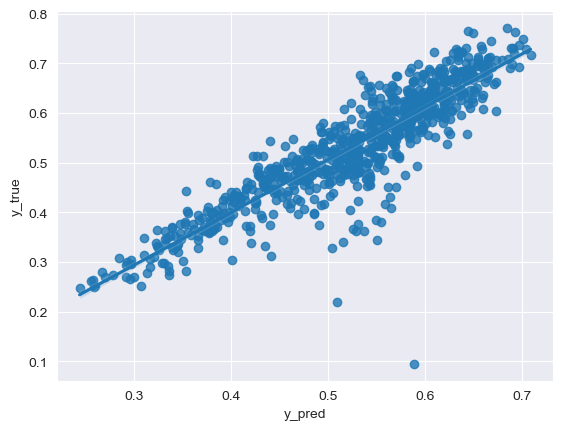

In [114]:
# dim 32 lay 2
plot_results(model, val)

MSE: 0.0027
R^2: 0.7913


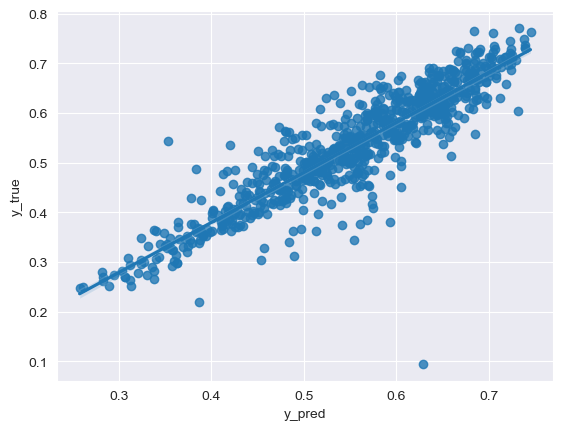

In [96]:
# dim 32 lay 2
plot_results(model, val)

MSE: 0.0025
R^2: 0.8087


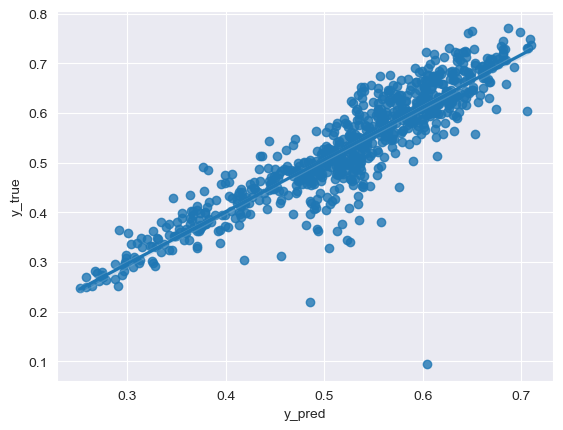

In [104]:
# dim 32 lay 4
plot_results(model, val)

MSE: 0.0027
R^2: 0.7962


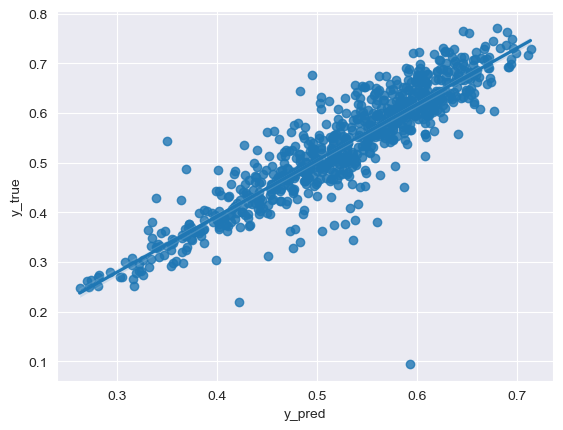

In [94]:
# dim 48 lay 2
plot_results(model, val)

MSE: 0.0025
R^2: 0.8091


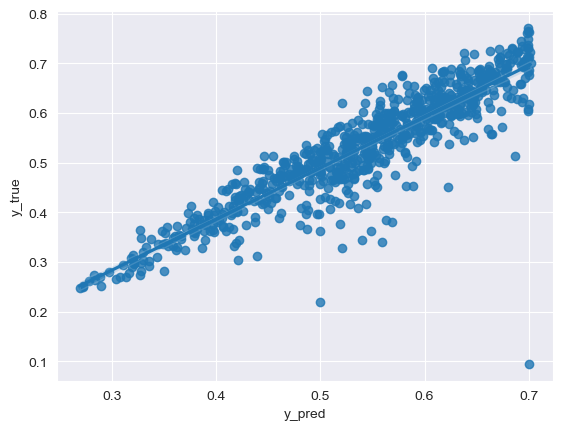

In [102]:
# dim 48 lay 4
plot_results(model, val)

MSE: 0.0023
R^2: 0.8306


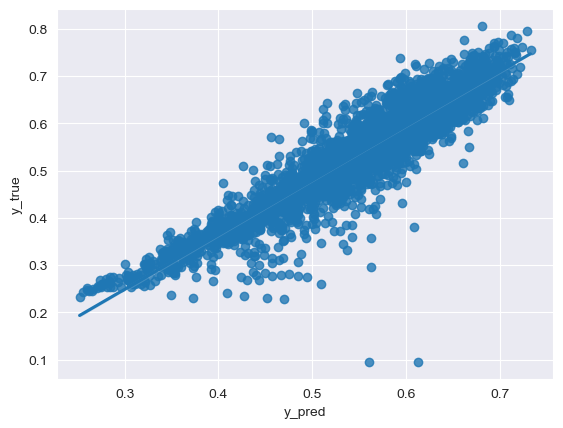

In [91]:


plot_results(model, train)

MSE: 0.0028
R^2: 0.7861


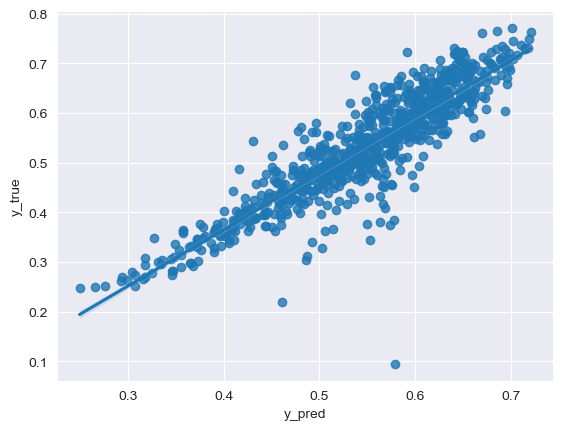

In [92]:
plot_results(model, val)

In [41]:
encoder.hash2model(df.iloc[0]['hash'], in_shape=(3, 32, 32), out_shape=10)

Conv2d       (128, 33, 33)  (4, 4)   (1, 1)  
PReLU        (128, 33, 33) 
BatchNorm2d  (128, 33, 33) 
Conv2d       (64, 33, 33)   (1, 1)   (1, 1)  
ReLU         (64, 33, 33)  
AvgPool2d    (64, 34, 34)   (4, 4)   (1, 1)  
Conv2d       (192, 14, 14)  (7, 7)   (2, 2)  
PReLU        (192, 14, 14) 
BatchNorm2d  (192, 14, 14) 
Conv2d       (64, 14, 14)   (7, 7)   (1, 1)  
ReLU         (64, 14, 14)  
MaxPool2d    (64, 11, 11)   (4, 4)   (1, 1)  
BatchNorm2d  (64, 11, 11)  
Conv2d       (128, 3, 3)    (2, 2)   (4, 4)  
PReLU        (128, 3, 3)   
GlobalAvgPool2d (128, 1, 1)   
Flatten      128           
Linear       1024          
ReLU         1024          
Dropout      1024           (0.15)  
Linear       128           
ReLU         128           
Dropout      128            (0.5)   
Linear       10            

In [88]:
model_id = 2555

with torch.no_grad():
    for i in df.index: 
        m = encoder.hash2model(df.loc[i, 'hash'], in_shape=(3, 32, 32), out_shape=10)
        t = torch.tensor(encoder.model2vec(m), dtype=torch.float32)
        df.loc[i, 'y_pred'] = model.cpu()(t).item()

# encoder.hash2model('00802122200000000044a0004000000000295000008024120808000000449000400000000080482210040000004510000024c80010080000400000000010000001000000', in_shape=(3, 32, 32), out_shape=10)

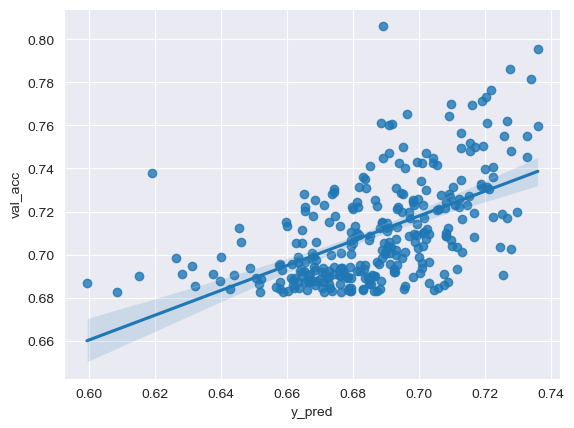

In [89]:
sns.regplot(df[:300], x='y_pred', y='val_acc');